**Market Segmentation Analysis**

In [13]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from statsmodels.formula.api import ols
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import silhouette_samples

In [90]:
# Load dataset
mcdonalds = pd.read_csv('/content/mcdonalds.csv')

In [15]:
print(mcdonalds.columns.values)

['yummy' 'convenient' 'spicy' 'fattening' 'greasy' 'fast' 'cheap' 'tasty'
 'expensive' 'healthy' 'disgusting' 'Like' 'Age' 'VisitFrequency' 'Gender']


In [16]:
mcdonalds.shape

(1453, 15)

In [17]:
print(mcdonalds.head(3))

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [18]:

# Convert "Yes"/"No" to 1/0 and compute column means
MD_x = (mcdonalds.iloc[:, 0:11] == "Yes").astype(int)
print(MD_x.mean().round(2))

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [19]:
# Assuming MD_x is the dataset as per the previous conversion
pca = PCA()
MD_pca = pca.fit(MD_x)

# Calculate standard deviation, proportion of variance, and cumulative variance
standard_deviation = np.sqrt(pca.explained_variance_)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


pca_results = pd.DataFrame({
    'Standard Deviation': np.round(standard_deviation, 4),
    'Proportion of Variance': np.round(explained_variance, 4),
    'Cumulative Proportion': np.round(cumulative_variance, 4)
}, index=[f'PC{i+1}' for i in range(len(standard_deviation))])

# Display the results
print("Importance of components:")
print(pca_results.T)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6  \
Standard Deviation      0.7570  0.6075  0.5046  0.3988  0.3374  0.3103   
Proportion of Variance  0.2994  0.1928  0.1330  0.0831  0.0595  0.0503   
Cumulative Proportion   0.2994  0.4922  0.6253  0.7084  0.7679  0.8182   

                           PC7     PC8     PC9    PC10    PC11  
Standard Deviation      0.2897  0.2751  0.2653  0.2488  0.2369  
Proportion of Variance  0.0438  0.0395  0.0368  0.0324  0.0293  
Cumulative Proportion   0.8620  0.9016  0.9383  0.9707  1.0000  


In [20]:
print("Standard deviations (1, .., p={0}):".format(len(standard_deviation)))
print(np.round(standard_deviation, 1))

# Loadings (Rotation matrix)
rotation_matrix = pd.DataFrame(np.round(pca.components_.T, 3),
                               index=mcdonalds.columns[:11],
                               columns=[f'PC{i+1}' for i in range(11)])

print("\nRotation (n x k) = ({0} x {1}):".format(*rotation_matrix.shape))
print(rotation_matrix)

Standard deviations (1, .., p=11):
[0.8 0.6 0.5 0.4 0.3 0.3 0.3 0.3 0.3 0.2 0.2]

Rotation (n x k) = (11 x 11):
              PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9  \
yummy      -0.477  0.364 -0.304  0.055 -0.308  0.171 -0.281  0.013  0.572   
convenient -0.155  0.016 -0.063 -0.142  0.278 -0.348 -0.060 -0.113 -0.018   
spicy      -0.006  0.019 -0.037  0.198  0.071 -0.355  0.708  0.376  0.400   
fattening   0.116 -0.034 -0.322 -0.354 -0.073 -0.407 -0.386  0.590 -0.161   
greasy      0.304 -0.064 -0.802  0.254  0.361  0.209  0.036 -0.138 -0.003   
fast       -0.108 -0.087 -0.065 -0.097  0.108 -0.595 -0.087 -0.628  0.166   
cheap      -0.337 -0.611 -0.149  0.119 -0.129 -0.103 -0.040  0.140  0.076   
tasty      -0.472  0.307 -0.287 -0.003 -0.211 -0.077  0.360 -0.073 -0.639   
expensive   0.329  0.601  0.024  0.068 -0.003 -0.261 -0.068  0.030  0.067   
healthy    -0.214  0.077  0.192  0.763  0.288 -0.178 -0.350  0.176 -0.186   
disgusting  0.375 -0.140 -0.089  0.370 -0

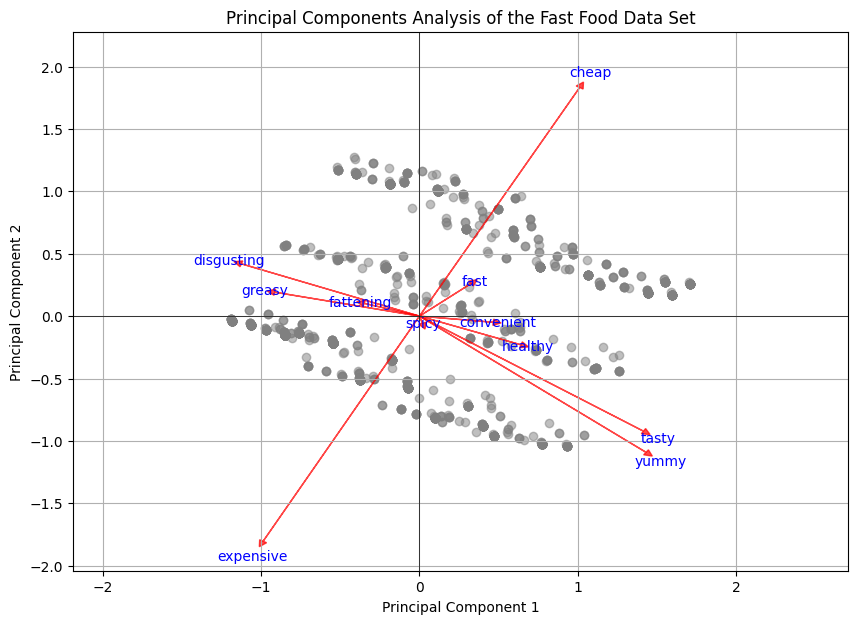

In [21]:
pca = PCA()
MD_pca = pca.fit_transform(MD_x)
loadings = pca.components_.T

# Plotting the PCA results
plt.figure(figsize=(10, 7))

# Plot the principal component scores
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], alpha=0.5, color='grey')

# Plot the loadings (arrows) and labels
for i in range(loadings.shape[0]):
    plt.arrow(0, 0, -loadings[i, 0] * 3, -loadings[i, 1] * 3,  # Scale arrows for visibility
              color='red', alpha=0.7, head_width=0.05, head_length=0.05)
    plt.text(-loadings[i, 0] * 3.2, -loadings[i, 1] * 3.2,  # Adjust text positioning
             mcdonalds.columns[i], color='blue', ha='center', va='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Components Analysis of the Fast Food Data Set')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Adjusting axis limits to ensure everything fits in the plot
plt.xlim(min(MD_pca[:, 0]) - 1, max(MD_pca[:, 0]) + 1)
plt.ylim(min(MD_pca[:, 1]) - 1, max(MD_pca[:, 1]) + 1)

plt.show()

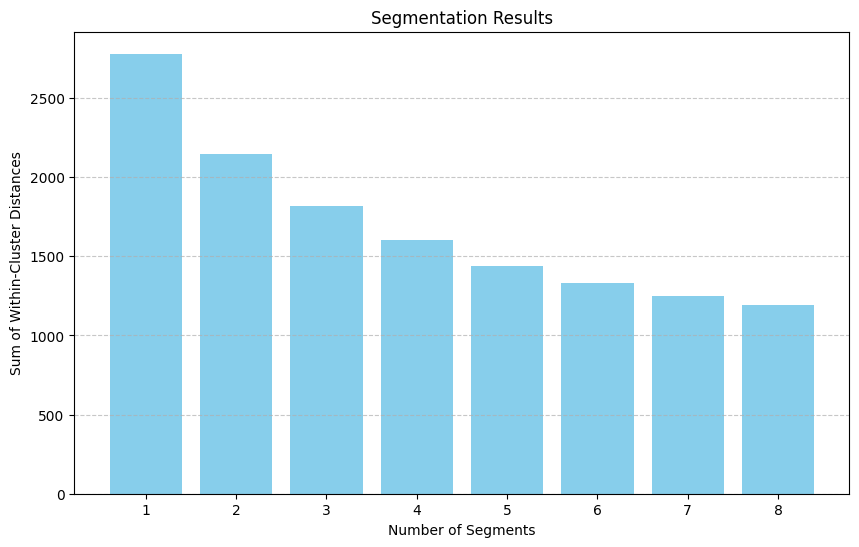

In [92]:
# Set seed for reproducibility
from sklearn.preprocessing import LabelEncoder
np.random.seed(1234)

# Define parameters
nrep = 10
num_segments = range(1, 9)
kmeans_models = []
within_cluster_distances = []

# Perform K-means clustering for each number of clusters
for k in num_segments:
    kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
    kmeans.fit(MD_x)
    kmeans_models.append(kmeans)
    within_cluster_distances.append(kmeans.inertia_)

# Re-label clusters to standardize the labels
# Note: KMeans doesn't have a direct relabel method;
# here we standardize the labels by reassigning them
def relabel_labels(models):
    relabeled_models = {}
    for model in models:
        labels = model.labels_
        # Create a new LabelEncoder to relabel the clusters
        encoder = LabelEncoder()
        new_labels = encoder.fit_transform(labels)
        relabeled_models[str(model.n_clusters)] = new_labels
    return relabeled_models

# Re-label the clusters
MD_km28_relabelled = relabel_labels(kmeans_models)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(num_segments, within_cluster_distances, color='skyblue')
plt.xlabel("Number of Segments")
plt.ylabel("Sum of Within-Cluster Distances")
plt.title("Segmentation Results")
plt.xticks(num_segments)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fro

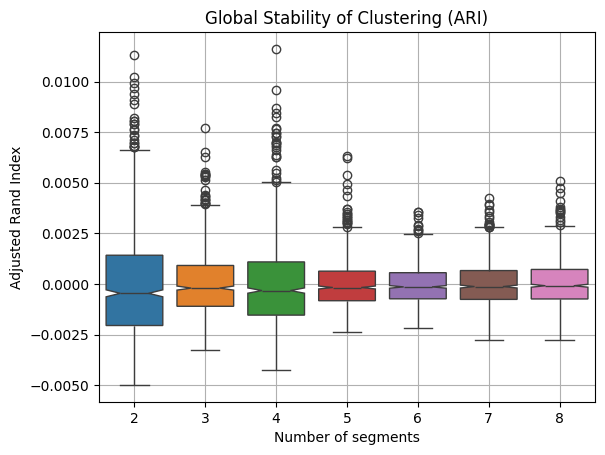

In [11]:
from sklearn.utils import resample

# Set seed for reproducibility
np.random.seed(1234)

# Assuming MD_x is the dataset
n_clusters = range(2, 9)  # Clusters from 2 to 8
n_rep = 10  # Number of repetitions
n_boot = 100  # Number of bootstrap iterations

# Store ARI results for each cluster count
ari_scores_dict = {k: [] for k in n_clusters}

# Loop through cluster counts
for k in n_clusters:
    # Repeat the process for n_rep times
    for _ in range(n_rep):
        # Perform bootstrapping (resampling)
        for _ in range(n_boot):
            X_resampled = resample(MD_x)

            # Fit KMeans on resampled data
            kmeans_resampled = KMeans(n_clusters=k, random_state=1234)
            kmeans_resampled.fit(X_resampled)

            # Fit KMeans on original data
            kmeans_original = KMeans(n_clusters=k, random_state=1234)
            kmeans_original.fit(MD_x)

            # Calculate ARI between the original and resampled clusters
            ari = adjusted_rand_score(kmeans_original.labels_, kmeans_resampled.labels_)
            ari_scores_dict[k].append(ari)

# Create a boxplot to show the global stability (ARI) for each number of clusters

sns.boxplot(data=[ari_scores_dict[k] for k in n_clusters], notch=True)
plt.xticks(ticks=range(len(n_clusters)), labels=n_clusters)
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global Stability of Clustering (ARI)')
plt.grid(True)
plt.show()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fro

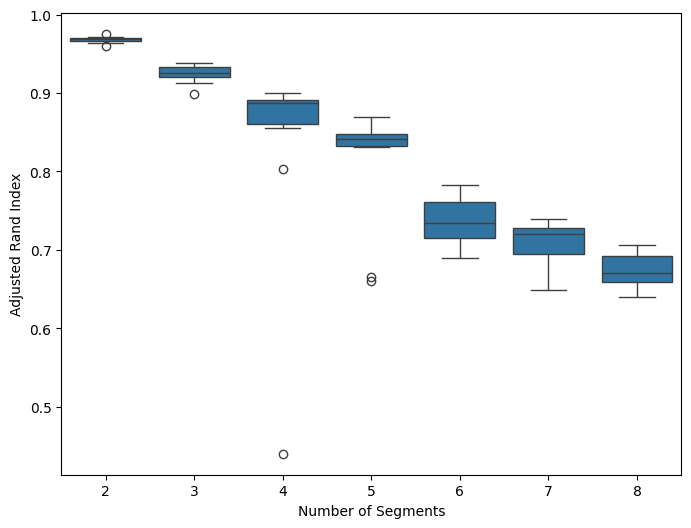

In [23]:
from sklearn.utils import resample

# Assuming you have the dataset MD_x as an array-like structure
np.random.seed(1234)

# Function to compute bootstrapped adjusted Rand index for KMeans clustering
def boot_kmeans_ari(X, k, n_boot=100, n_rep=10):
    ari_scores = []
    for _ in range(n_rep):
        labels_true = KMeans(n_clusters=k, random_state=np.random.randint(10000)).fit_predict(X)
        boot_ari = []
        for _ in range(n_boot):
            X_resample, labels_resample = resample(X, labels_true, random_state=np.random.randint(10000))
            labels_pred = KMeans(n_clusters=k, random_state=np.random.randint(10000)).fit_predict(X_resample)
            ari = adjusted_rand_score(labels_resample, labels_pred)
            boot_ari.append(ari)
        ari_scores.append(np.mean(boot_ari))
    return ari_scores

# Generate ARI scores for different numbers of segments
segment_range = range(2, 9)
ari_data = {k: boot_kmeans_ari(MD_x, k) for k in segment_range}

# Convert to list for boxplot
ari_scores_list = [(k, score) for k in ari_data for score in ari_data[k]]

# Create a DataFrame from the list
ari_df = pd.DataFrame(ari_scores_list, columns=['number_of_segments', 'ari_score'])

# Plot the data
plt.figure(figsize=(8, 6))
sns.boxplot(x='number_of_segments', y='ari_score', data=ari_df)
plt.xlabel("Number of Segments")
plt.ylabel("Adjusted Rand Index")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


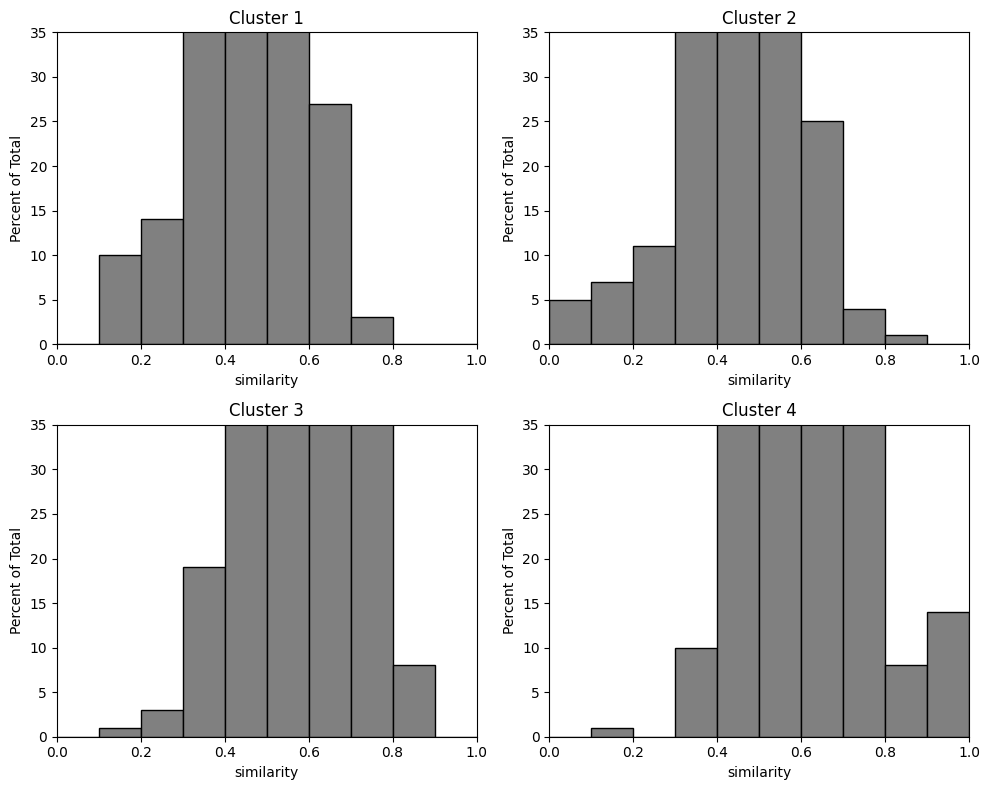

In [24]:
# Apply KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=1234)
labels = kmeans.fit_predict(MD_x)

# Plot histograms for each cluster
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i in range(4):
    cluster_data = MD_x[labels == i]  # Data for the current cluster
    similarity = np.mean(cluster_data, axis=1)  # Placeholder for 'similarity' score

    # Plot the histogram for each cluster
    axes[i].hist(similarity, bins=10, range=(0, 1), color='grey', edgecolor='black')
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 35)
    axes[i].set_title(f"Cluster {i+1}")
    axes[i].set_xlabel('similarity')
    axes[i].set_ylabel('Percent of Total')

plt.tight_layout()
plt.show()

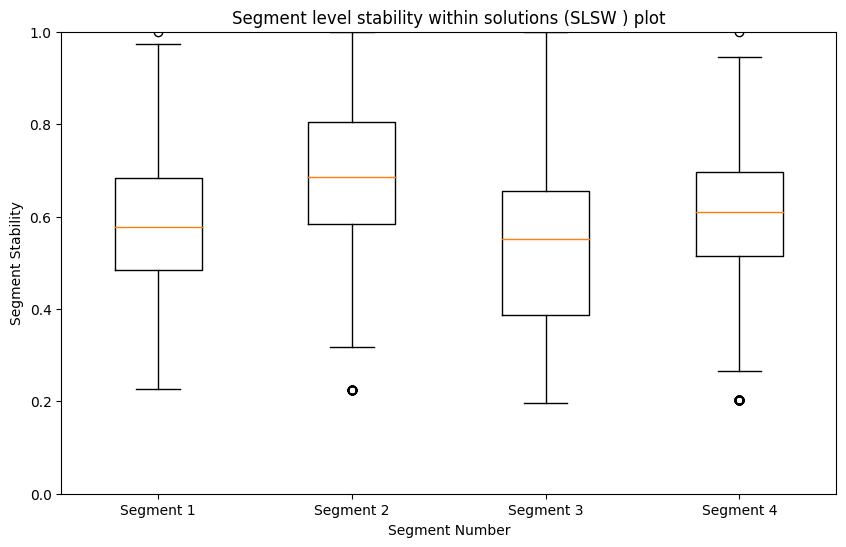

In [25]:
# Fit KMeans for each number of clusters from 2 to 8
MD_km28 = {k: KMeans(n_clusters=k, n_init=10, random_state=1234).fit(MD_x) for k in range(2, 9)}

# Extract the KMeans model for 4 clusters
MD_k4 = MD_km28[4]

# Calculate distances to the nearest cluster center for each point
distances = MD_k4.transform(MD_x)  # Shape: (n_samples, n_clusters)

# Calculate stability for each segment by finding the minimum distance to cluster centers
stability_values = {i: [] for i in range(4)}

# Store the stability for each segment
for i in range(4):
    stability_values[i] = distances[:, i]

# Normalize stability values to a 0-1 range
stability_values_normalized = {i: stability / np.max(stability) for i, stability in stability_values.items()}

# Prepare data for boxplot
stability_data = [stability_values_normalized[i] for i in range(4)]

# Plotting the segment stability
plt.figure(figsize=(10, 6))
plt.boxplot(stability_data, labels=['Segment 1', 'Segment 2', 'Segment 3', 'Segment 4'])
plt.ylim(0, 1)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.title("Segment level stability within solutions (SLSW ) plot")
plt.show()

In [26]:
from sklearn.mixture import GaussianMixture

# Set seed for reproducibility
np.random.seed(1234)


# Fit Gaussian Mixture Models for k = 2 to 8
results = []
for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    logLik = gmm.score(MD_x) * MD_x.shape[0]
    aic = gmm.aic(MD_x)
    bic = gmm.bic(MD_x)
    entropy = -np.sum(gmm.predict_proba(MD_x) * np.log(gmm.predict_proba(MD_x) + 1e-10))
    icl = bic - entropy
    converged = gmm.converged_
    iter_count = gmm.n_iter_
    results.append((iter_count, converged, k, k, logLik, aic, bic, icl))

# Print results
print("iter\tconverged\tk\tk0\tlogLik\t\tAIC\t\tBIC\t\tICL")
for res in results:
    print(f"{res[0]}\t{res[1]}\t\t{res[2]}\t{res[3]}\t{res[4]:.2f}\t{res[5]:.2f}\t{res[6]:.2f}\t{res[7]:.2f}")

iter	converged	k	k0	logLik		AIC		BIC		ICL
7	True		2	2	11147.82	-21985.64	-21167.03	-21167.03
12	True		3	3	14126.45	-27786.90	-26556.34	-26556.34
11	True		4	4	17513.54	-34405.08	-32762.57	-32763.28
18	True		5	5	22500.93	-44223.86	-42169.40	-42169.52
8	True		6	6	28522.04	-56110.08	-53643.68	-53643.68
18	True		7	7	29652.48	-58214.95	-55336.60	-55336.83
12	True		8	8	26714.81	-52183.62	-48893.32	-48894.10


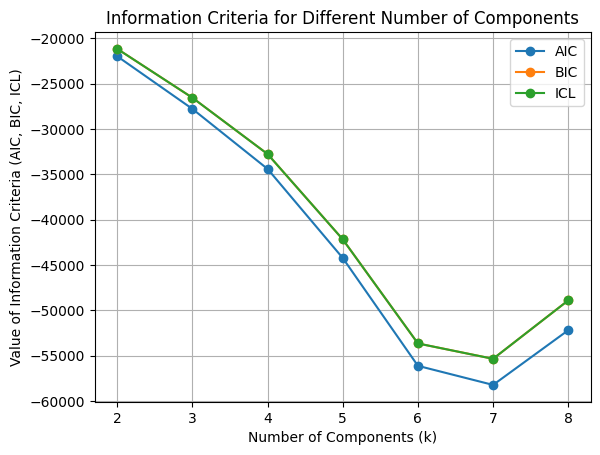

In [27]:
# Extract values for plotting
k_values = [res[2] for res in results]
aic_values = [res[5] for res in results]
bic_values = [res[6] for res in results]
icl_values = [res[7] for res in results]

# Plotting the values
plt.plot(k_values, aic_values, label='AIC', marker='o')
plt.plot(k_values, bic_values, label='BIC', marker='o')
plt.plot(k_values, icl_values, label='ICL', marker='o')

plt.xlabel('Number of Components (k)')
plt.ylabel('Value of Information Criteria (AIC, BIC, ICL)')
plt.title('Information Criteria for Different Number of Components')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(MD_x)
kmeans_labels = kmeans.labels_

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=0).fit(MD_x)
gmm_labels = gmm.predict(MD_x)

# Create a DataFrame with the clustering results
df = pd.DataFrame({
    'kmeans': kmeans_labels,
    'mixture': gmm_labels
})

# Generate the contingency table
contingency_table = pd.crosstab(df['kmeans'], df['mixture'])
print(contingency_table)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


mixture    0    1   2    3
kmeans                    
0        261    0  48    0
1         14    0  65  501
2          7  224  45   48
3         36  185  19    0


In [29]:
# Fit Gaussian Mixture Model for MD.m4a
gmm_m4a = GaussianMixture(n_components=4, random_state=1234)
gmm_m4a.fit(MD_x)
logLik_m4a = gmm_m4a.score(MD_x) * MD_x.shape[0]

# Fit Gaussian Mixture Model for MD.m4
gmm_m4 = GaussianMixture(n_components=4, random_state=1234)
gmm_m4.fit(MD_x)
logLik_m4 = gmm_m4.score(MD_x) * MD_x.shape[0]

print(f"logLik(MD.m4a): {logLik_m4a}")
print(f"logLik(MD.m4): {logLik_m4}")

logLik(MD.m4a): 13740.70387994845
logLik(MD.m4): 13740.70387994845


In [30]:
like_counts = mcdonalds['Like'].value_counts().iloc[::-1]

print(like_counts)

Like
-1               58
-2               59
-4               71
-3               73
I love it!+5    143
I hate it!-5    152
+1              152
+4              160
0               169
+2              187
+3              229
Name: count, dtype: int64


In [105]:


# Define a function to convert 'Like' values to numeric
def convert_like(value):
    if value.startswith('I love it!'):
        return 5
    elif value.startswith('I hate it!'):
        return -5
    else:
        return int(value)

# Apply the conversion function to 'Like' column
mcdonalds['Like_numeric'] = mcdonalds['Like'].apply(convert_like)
mcdonalds['count'] = 1
# Generate the frequency table
frequency_table = mcdonalds.groupby('Like_numeric')['count'].sum()

# Display the frequency table
print(frequency_table.sort_index())


Like_numeric
-5    152
-4     71
-3     73
-2     59
-1     58
 0    169
 1    152
 2    187
 3    229
 4    160
 5    143
Name: count, dtype: int64


In [32]:
columns = list(mcdonalds.columns[:11])
formula_string = "Like.n ~ " + " + ".join(columns)

print(formula_string)

Like.n ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting


In [104]:
from sklearn.preprocessing import StandardScaler
# Standardize features (optional)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(MD_x)

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=1234, n_init=10)
gmm.fit(X_scaled)

# Predict cluster labels
labels = gmm.predict(X_scaled)

# Compute cluster sizes
cluster_sizes = np.bincount(labels)

# Print the results
print("Cluster sizes:")
print("1    2")
print(f"{cluster_sizes[0]} {cluster_sizes[1]}")
print(f"Convergence after {gmm.n_iter_} iterations")

Cluster sizes:
1    2
393 1060
Convergence after 8 iterations


In [103]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Fit the model
gmm = GaussianMixture(n_components=2, random_state=1234, n_init=10)
gmm.fit(X_scaled)

# Refit the model
gmm_refit = GaussianMixture(n_components=2, random_state=1234, n_init=10)
gmm_refit.fit(X_scaled)

# Function to calculate z-values and p-values
def calculate_statistics(means, covariances):
    estimates = means.flatten()
    std_errors = np.sqrt(np.diagonal(covariances, axis1=1, axis2=2)).flatten()
    z_values = estimates / std_errors
    p_values = 2 * (1 - norm.cdf(np.abs(z_values)))
    return estimates, std_errors, z_values, p_values

# Get statistics for each component
estimates, std_errors, z_values, p_values = calculate_statistics(gmm_refit.means_, gmm_refit.covariances_)

# Print the results in the desired format
print("Estimate\tStd. Error\tz value\t\tPr(>|z|)")
for i in range(len(estimates)):
    print(f"{estimates[i]:.4f}\t\t{std_errors[i]:.3f}\t\t{z_values[i]:.3f}\t\t{p_values[i]:.3f}")

# Print convergence details
print(f"\nConvergence after {gmm_refit.n_iter_} iterations")

# Optional: Display prediction probabilities for components
responsibilities = gmm_refit.predict_proba(X_scaled)
print("\nPrediction Probabilities for each component (first 5 samples):")
print(responsibilities[:5])


Estimate	Std. Error	z value		Pr(>|z|)
-0.6867		0.821		-0.837		0.403
-0.8597		1.638		-0.525		0.600
0.0368		1.049		0.035		0.972
0.1515		0.806		0.188		0.851
0.4897		0.842		0.582		0.561
-0.2613		1.277		-0.205		0.838
-0.2249		1.020		-0.220		0.825
-0.7077		0.962		-0.736		0.462
0.3257		1.043		0.312		0.755
-0.2943		0.685		-0.430		0.668
1.5279		0.705		2.167		0.030
0.2546		0.939		0.271		0.786
0.3187		0.001		318.735		0.000
-0.0137		0.981		-0.014		0.989
-0.0562		1.058		-0.053		0.958
-0.1816		0.993		-0.183		0.855
0.0969		0.856		0.113		0.910
0.0834		0.980		0.085		0.932
0.2624		0.879		0.298		0.765
-0.1207		0.956		-0.126		0.899
0.1091		1.074		0.102		0.919
-0.5665		0.001		-566.488		0.000

Convergence after 8 iterations

Prediction Probabilities for each component (first 5 samples):
[[1.60201592e-10 1.00000000e+00]
 [6.90756315e-10 9.99999999e-01]
 [5.56032808e-12 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [2.43349916e-13 1.00000000e+00]]


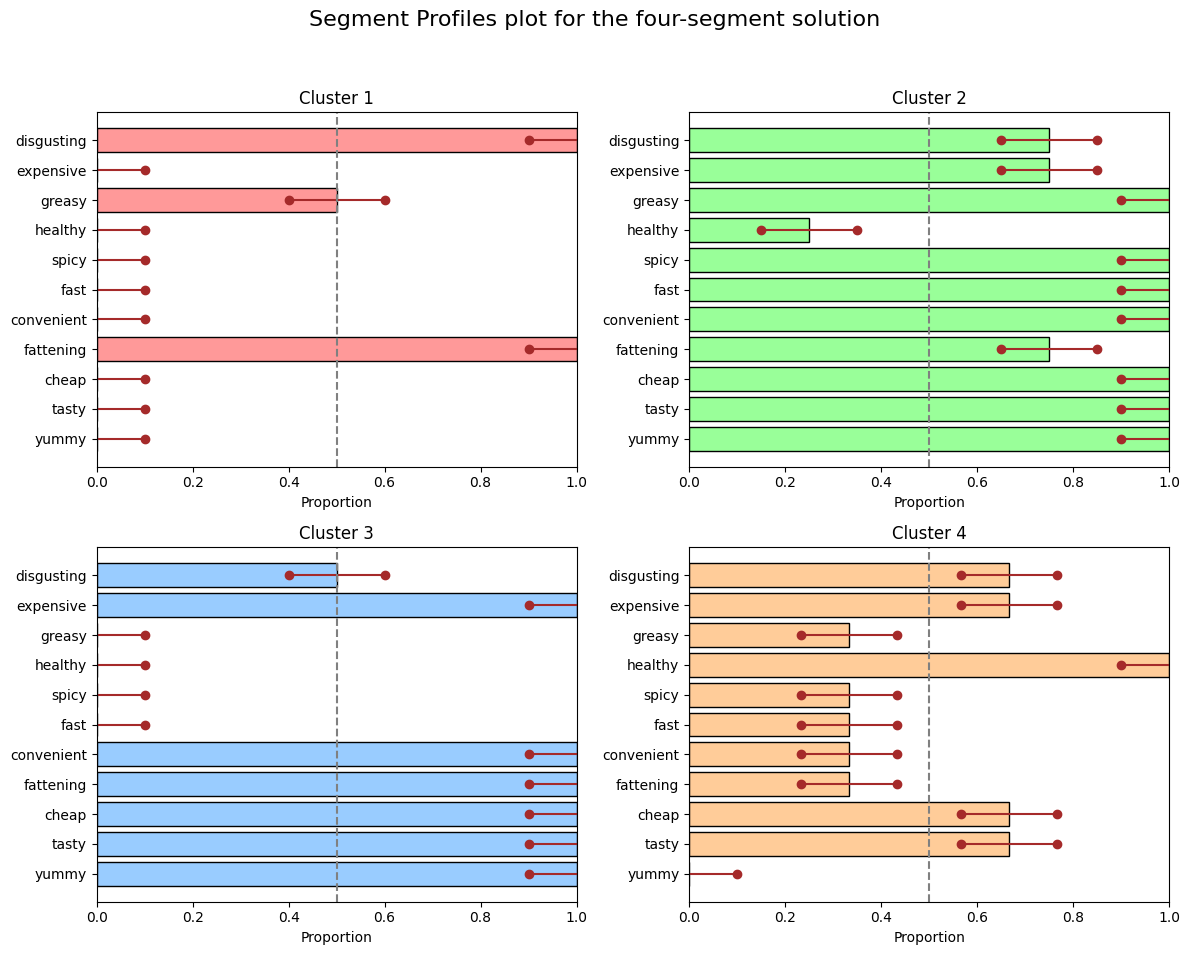

In [100]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans


# Perform hierarchical clustering
MD_vclust = linkage(pdist(MD_x.T), method='ward')

# Get order of clusters based on hierarchical clustering
order = dendrogram(MD_vclust, no_plot=True)['leaves'][::-1]

# Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234, n_init=10).fit(MD_x.T)
labels = kmeans.labels_

# Convert numpy array to pandas DataFrame
MD_x_df = pd.DataFrame(MD_x.T)

# Calculate mean for each cluster
MD_mean = MD_x_df.groupby(labels).mean()

# Define labels (y-axis)
y_labels = ['yummy', 'tasty', 'cheap', 'fattening', 'convenient', 'fast', 'spicy', 'healthy', 'greasy', 'expensive', 'disgusting']

# Adjusting the order of features based on clustering
MD_mean = MD_mean[order]

# Plot the bar chart
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
clusters = [0, 1, 2, 3]
titles = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
colors = ['#FF9999', '#99FF99', '#99CCFF', '#FFCC99']  # Custom colors for clusters

# Loop over each cluster and plot
for i, ax in enumerate(axs.flat):
    # Plot horizontal bars for each variable in the current cluster
    ax.barh(range(len(y_labels)), MD_mean.iloc[i], color=colors[i], edgecolor='black')

    # Add confidence intervals (dummy values for now)
    for j, (mean, cluster_value) in enumerate(zip(MD_mean.iloc[i], MD_mean.iloc[i])):
        ax.plot([mean - 0.1, mean + 0.1], [j, j], color='brown', marker='o')  # Mock confidence intervals

    # Add title and axis labels
    ax.set_title(titles[i])
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Proportion')
    ax.axvline(0.5, linestyle='--', color='gray')  # Add a reference line for better readability

# Adjust layout and add a main title
fig.suptitle('Segment Profiles plot for the four-segment solution', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-101-03974f42f478>:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=color, label=cluster_names[i],


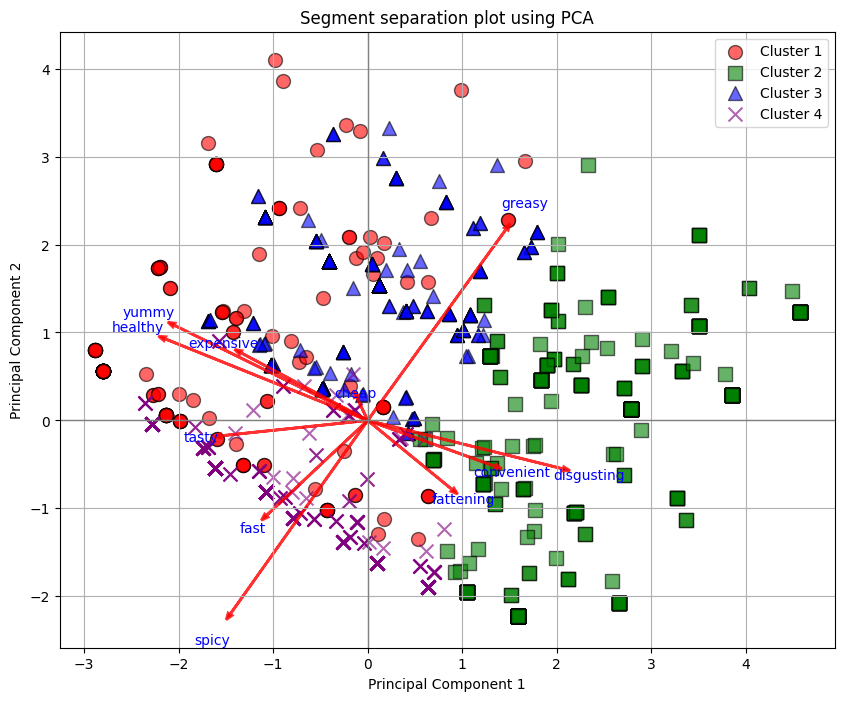

In [101]:

from sklearn.preprocessing import StandardScaler

# Assuming MD_x is the dataset loaded as a numpy array or pandas DataFrame
# Standardize the data before applying PCA
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x)

# Perform PCA to project the data onto two principal components
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x_scaled)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
labels = kmeans.fit_predict(MD_x_scaled)

# Plot settings
colors = ['red', 'green', 'blue', 'purple']
markers = ['o', 's', '^', 'x']
cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
y_labels = ['yummy', 'tasty', 'cheap', 'fattening', 'convenient', 'fast', 'spicy', 'healthy', 'greasy', 'expensive', 'disgusting']

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each cluster
for i, (color, marker) in enumerate(zip(colors, markers)):
    cluster_points = MD_pca[labels == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=color, label=cluster_names[i],
               marker=marker, edgecolor='black', s=100, alpha=0.6)

# Plot the PCA feature vectors (loadings)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, (feature, vec) in enumerate(zip(y_labels, loadings)):
    ax.arrow(0, 0, vec[0]*3, vec[1]*3, color='red', alpha=0.8, head_width=0.05, lw=2)
    ax.text(vec[0] * 3.4, vec[1] * 3.4, feature, color='blue', ha='center', va='center')

# Customize plot
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(loc='upper right')
ax.set_title('Segment separation plot using PCA')

# Show the plot
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Figure size 1500x700 with 0 Axes>

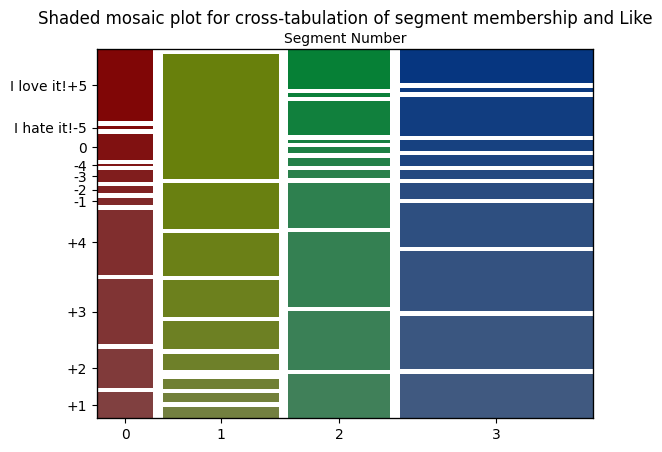

In [94]:

kmeans = KMeans(n_clusters=4, random_state=1234)
k4 = kmeans.fit_predict(MD_x_scaled)  # Cluster labels

# Add the cluster labels to the DataFrame
mcdonalds['Cluster'] = k4

# Cross-tabulate the clusters (k4) with the "Like" column
crosstab = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Like'])

# Convert the crosstab to a format compatible with the mosaic function
mosaic_data = crosstab.stack()

# Plot the shaded mosaic plot
plt.figure(figsize=(15, 7))
mosaic(mosaic_data, title='Shaded mosaic plot for cross-tabulation of segment membership and Like', gap=0.02, labelizer=lambda k: '', axes_label=True)
plt.xlabel('Segment Number')
plt.ylabel('Like')

plt.show()

<Figure size 1500x700 with 0 Axes>

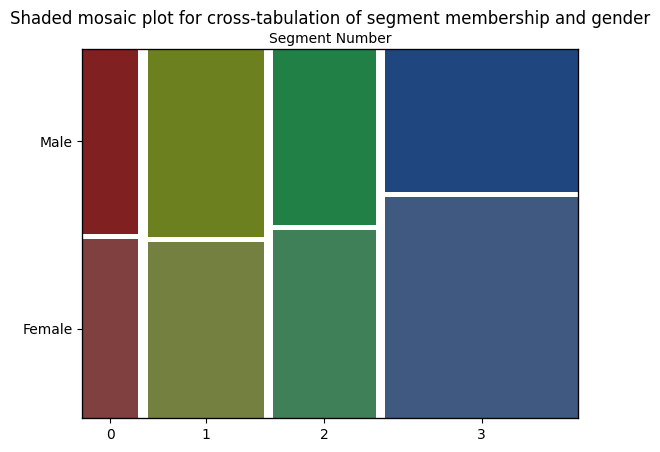

In [96]:
crosstab = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Gender'])

# Convert the crosstab to a format compatible with the mosaic function
mosaic_data = crosstab.stack()

# Plot the shaded mosaic plot
plt.figure(figsize=(15, 7))
mosaic(mosaic_data, title='Shaded mosaic plot for cross-tabulation of segment membership and gender', gap=0.02, labelizer=lambda k: '', axes_label=True)

plt.xlabel('Segment Number')
plt.ylabel('Like')

plt.show()

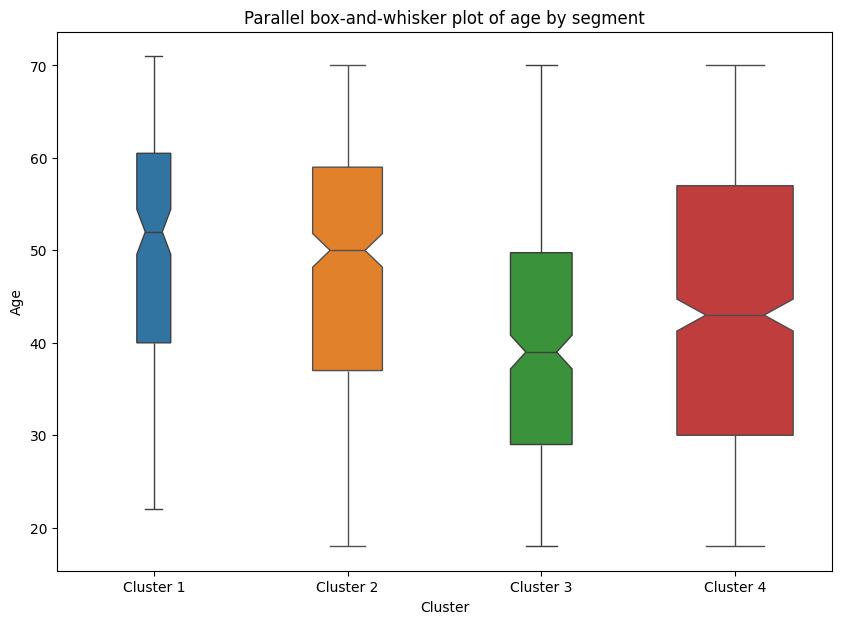

In [97]:


# Count the number of data points in each cluster to manually adjust the width
cluster_counts = mcdonalds['Cluster'].value_counts().sort_index()

# Normalize the counts to get proportional widths
cluster_proportions = cluster_counts / cluster_counts.max()

# Create a figure and axes
plt.figure(figsize=(10, 7))

# Create a boxplot for each cluster
for i, proportion in enumerate(cluster_proportions):
    # Filter the data for the i-th cluster
    cluster_data = mcdonalds[mcdonalds['Cluster'] == i]

    # Plot the boxplot with the corresponding width
    sns.boxplot(x=[i] * len(cluster_data), y=cluster_data['Age'], notch=True, width=proportion * 0.6)

# Customize the plot
plt.xticks(ticks=range(len(cluster_proportions)), labels=[f"Cluster {i+1}" for i in range(len(cluster_proportions))])
plt.title('Parallel box-and-whisker plot of age by segment')
plt.xlabel('Cluster')
plt.ylabel('Age')

# Show the plot
plt.show()


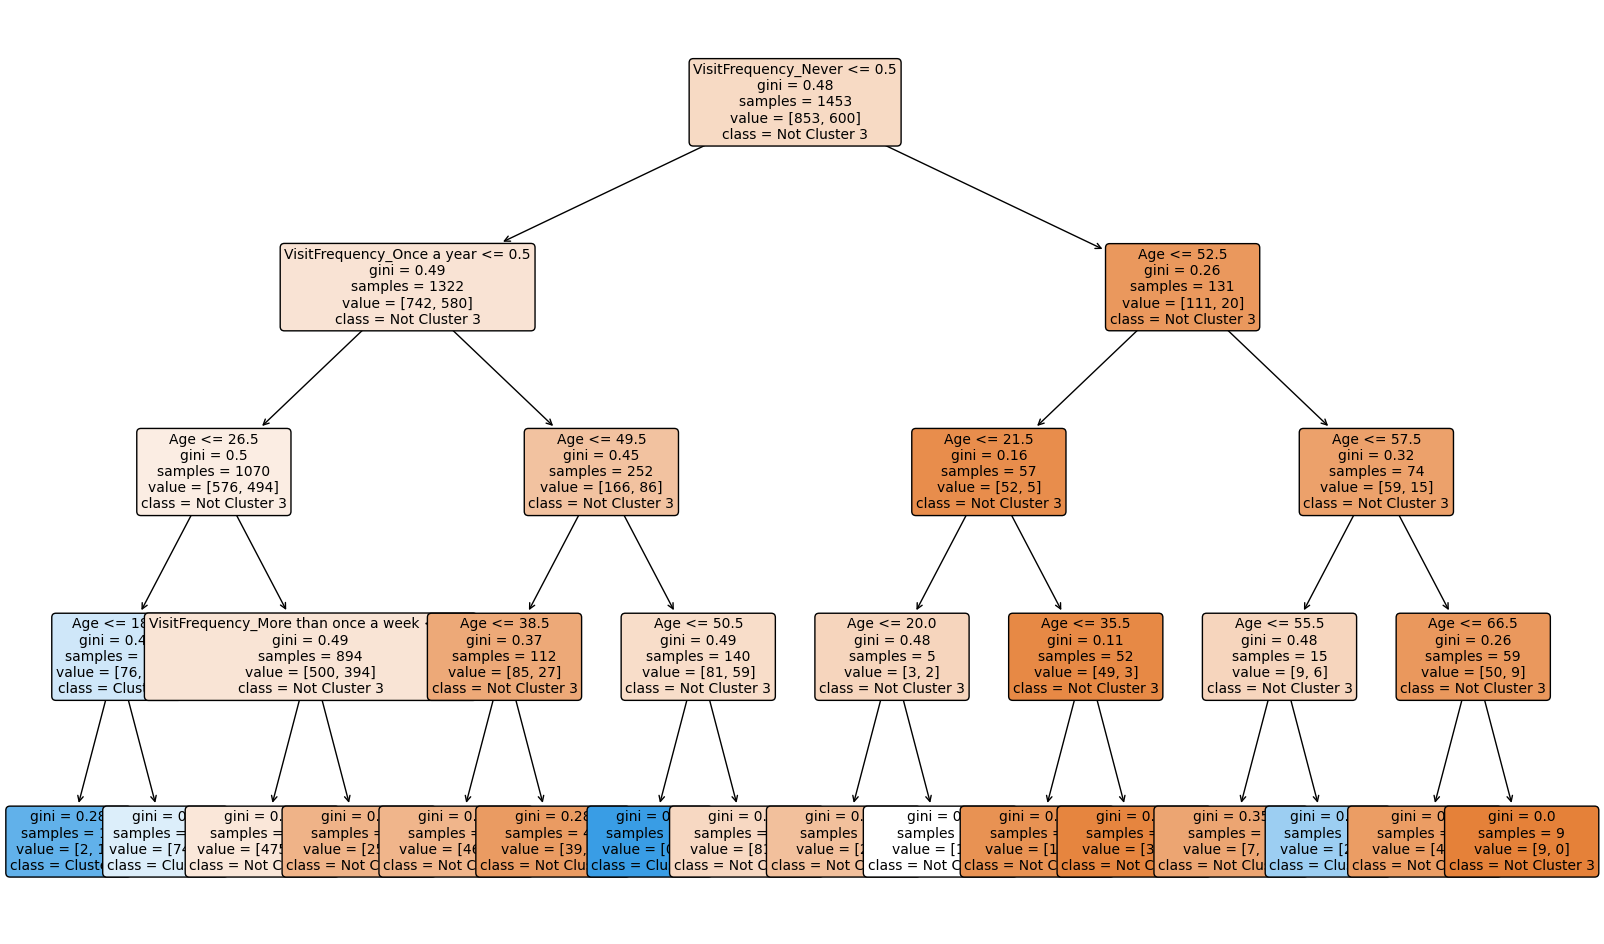

In [98]:

from sklearn.tree import DecisionTreeClassifier, plot_tree



# Create a target variable 'Target' where Cluster == 3
mcdonalds['Target'] = (mcdonalds['Cluster'] == 3).astype(int)

# Adjust the mapping for 'Like.n' to represent both positive and negative sentiments
like_mapping = {
    'I love it!': 5,
    'I hate it!': -5
}
mcdonalds['Like.n_numeric'] = mcdonalds['Like'].map(like_mapping)

# One-hot encoding for 'VisitFrequency'
visit_freq_dummies = pd.get_dummies(mcdonalds['VisitFrequency'], prefix='VisitFrequency')

# Only include the independent variables LIKE.N, AGE, and VISITFREQUENCY (remove Gender)
X = pd.concat([mcdonalds[['Like.n_numeric', 'Age']], visit_freq_dummies], axis=1)

# The target variable
y = mcdonalds['Target']

# Initialize and fit the decision tree
tree = DecisionTreeClassifier(random_state=42, max_depth=4)  # Adjust max_depth to control complexity
tree.fit(X, y)

# Plot the decision tree with enhanced details
plt.figure(figsize=(20, 12))  # Larger figure size for better clarity

plot_tree(tree,
          feature_names=X.columns,
          class_names=['Not Cluster 3', 'Cluster 3'],
          filled=True,
          rounded=True,
          fontsize=10,  # Larger font size for better readability
          precision=2)  # Precision for numerical values in the nodes

# Show the plot
plt.show()


In [110]:

visit_mapping = {'Once a week': 7, 'Once a month': 1, 'Every three months': 3, 'Rarely': 0.5}  # Example
mcdonalds['VisitFrequency_numeric'] = mcdonalds['VisitFrequency'].map(visit_mapping)

# Group by 'k4' (cluster assignment) and calculate the mean of 'VisitFrequency_numeric'
visit_means = mcdonalds.groupby('Cluster')['VisitFrequency_numeric'].mean()
print(visit_means)


Cluster
0    3.125874
1    2.971429
2    2.953846
3    3.126850
Name: VisitFrequency_numeric, dtype: float64


In [107]:
# Group the 'Like.n' column by the cluster (k4) and calculate the mean
like_means = mcdonalds.groupby('Cluster')['Like_numeric'].mean()

# Display the result in the required format
print(like_means)

Cluster
0    2.582857
1   -2.805556
2    2.116352
3    1.690000
Name: Like_numeric, dtype: float64


In [112]:
# Convert 'Gender' to a binary variable where 'Female' is 1 and others are 0.
mcdonalds['is_female'] = (mcdonalds['Gender'] == 'Female').astype(int)

# Calculate the mean of 'is_female' for each cluster in 'Cluster'.
female_means = mcdonalds.groupby('Cluster')['is_female'].mean()

print(female_means)

Cluster
0    0.491429
1    0.483333
2    0.515723
3    0.606667
Name: is_female, dtype: float64


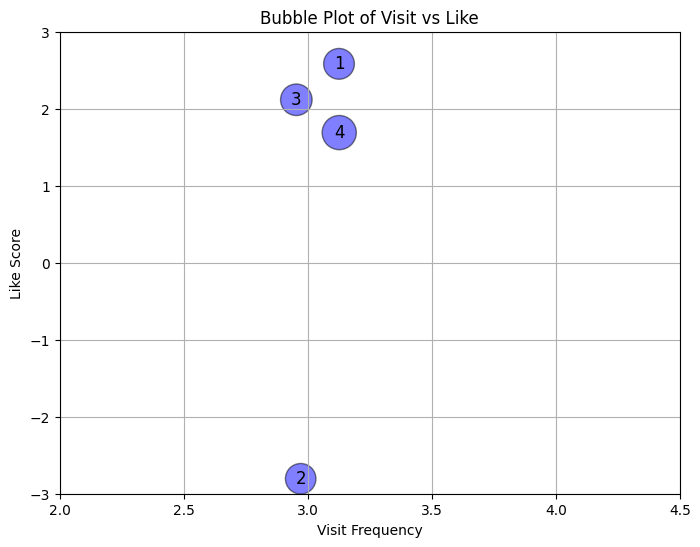

In [113]:
import matplotlib.pyplot as plt


# Adjust 'cex' in R to 'size' in matplotlib (e.g., scale by multiplying by 10)
bubble_sizes = 10 * female_means

# Plot the points with the specified limits
plt.figure(figsize=(8, 6))
plt.scatter(visit_means, like_means, s=bubble_sizes * 100, alpha=0.5, color='blue', edgecolor='black')  # Multiply size by 100 for better visualization

# Set the limits for x and y axes
plt.xlim(2, 4.5)
plt.ylim(-3, 3)

# Add text labels (cluster numbers)
for i, (x, y) in enumerate(zip(visit_means, like_means), 1):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center', color='black')

# Add labels and title (if needed)
plt.xlabel("Visit Frequency")
plt.ylabel("Like Score")
plt.title("Bubble Plot of Visit vs Like")

# Show the plot
plt.grid(True)
plt.show()
